In [29]:
import os
import sys
import glob

import ase.collections
import numpy as np
import copy
import yaml

import argparse

import ase.build
import ase.optimize
import ase.io.trajectory
import ase.visualize
import ase.vibrations
import logging

import ase.io
import ase.mep

import fairchem.core.models.model_registry
import fairchem.core.common.relaxation.ase_utils

import matplotlib.pyplot as plt

sys.path.append(os.environ['SURFACE_THERMO_DIR'])
# sys.path.append('/home/moon/surface/surface_thermo')
import util

# Define the system

In [3]:
# slab_name = 'Cr2O3_z'
# slab_name = 'Fe_fcc111'
slab_name = 'Cr_bcc110'
element = 'N'

results_dir = os.path.join(os.environ['SURFACE_THERMO_DIR'], 'results')
slab_file = os.path.join(results_dir, 'slab', f'{slab_name}_slab.traj')

working_dir = os.path.join(results_dir, 'diffusion', f'{slab_name}_{element}')
os.makedirs(working_dir, exist_ok=True)

traj = ase.io.trajectory.Trajectory(slab_file)
slab = traj[-1]


In [4]:
local_cache = os.environ['FAIRCHEM_LOCAL_CACHE']
checkpoint_path = fairchem.core.models.model_registry.model_name_to_local_file(
    'GemNet-OC-S2EFS-nsn-OC20+OC22',
    # 'EquiformerV2-31M-S2EF-OC20-All+MD',
    # local_cache='/home/moon/surface/tmp/fairchem_checkpoints/'
    local_cache=local_cache
)
calc = fairchem.core.common.relaxation.ase_utils.OCPCalculator(
    checkpoint_path=checkpoint_path,
    cpu=True,
    seed=400
)


/home/moon/fairchem_env/lib/python3.12/site-packages/fairchem/core/models/scn/spherical_harmonics.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd = torch.load(os.pa

# Manually find the site for testing the diffusion

In [10]:
test_system = copy.deepcopy(slab)

adsorbate = ase.build.molecule(element)


a = 3.44249999999999999  # Cr_bcc110
site = np.array(slab.info['adsorbate_info']['sites']['hollow']) * a

# site = (1.74707631e+00, 2.75179683e+00) Cr2O3?
height = 0.0

ase.build.add_adsorbate(test_system, adsorbate, height=height, position=site)
surface_height = test_system.positions[-1, 2]


ase.visualize.view(test_system, viewer='x3d')

# Do a quick calculation of energies at different heights

In [37]:
system = copy.deepcopy(slab)
heights = np.linspace(-5.0, 4.0, 21)
energies = np.zeros(len(heights))
test_system = copy.deepcopy(slab)
for i, height in enumerate(heights):
    ase.build.add_adsorbate(test_system, adsorbate, height=height, position=site)
    test_system.positions[-1, 2] = height + surface_height
    test_system.calc = calc
    
    system_trajectory_file = os.path.join(working_dir, f'vertical_pes_{i}.traj')

    fmax = 0.05
    MAXSTEP = 0
    opt = ase.optimize.BFGS(test_system, trajectory=system_trajectory_file)
    opt.run(fmax=fmax, steps=MAXSTEP)
    energies[i] = test_system.get_potential_energy()
    
    # remove the adsorbate for the next iteration
    test_system = test_system[:len(slab)]


      Step     Time          Energy          fmax
BFGS:    0 12:32:51     -303.690918       22.109577
      Step     Time          Energy          fmax
BFGS:    0 12:32:55     -303.970490       37.106800
      Step     Time          Energy          fmax
BFGS:    0 12:32:57     -305.319763       51.909592
      Step     Time          Energy          fmax
BFGS:    0 12:32:59     -304.845642       53.028111
      Step     Time          Energy          fmax
BFGS:    0 12:33:01     -302.610443       15.029783
      Step     Time          Energy          fmax
BFGS:    0 12:33:03     -306.973663       61.704498
      Step     Time          Energy          fmax
BFGS:    0 12:33:05     -307.740112       11.523464
      Step     Time          Energy          fmax
BFGS:    0 12:33:07     -306.570526        5.770255
      Step     Time          Energy          fmax
BFGS:    0 12:33:08     -308.210693       36.748428
      Step     Time          Energy          fmax
BFGS:    0 12:33:11     -302.341

In [38]:
vertical_pes = np.zeros((len(heights), 2))
vertical_pes[:, 0] = heights
vertical_pes[:, 1] = energies
np.save(os.path.join(working_dir, 'vertical_pes'), vertical_pes) 

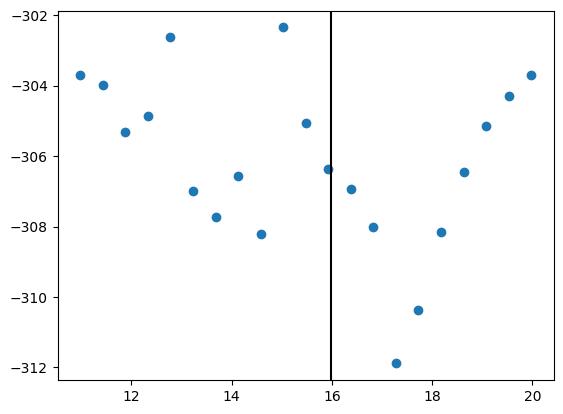

In [39]:
plt.scatter(heights + surface_height, height_energies)
plt.axvline(x=surface_height, color='k', label='Surface')

# Find some of the possible minima

In [25]:
zs1 = np.linspace(13.8, 15.0, 9)  # <--------------------- fill this in yourself
test_system = copy.deepcopy(slab)
for i, z in enumerate(zs1):
    print(i)
    ase.build.add_adsorbate(test_system, adsorbate, height=0, position=site)
    test_system.positions[-1, 2] = z
    test_system.calc = calc
    
    system_trajectory_file = os.path.join(working_dir, f'minima1_{i}.traj')

    fmax = 0.05
    MAXSTEP = 100
    opt = ase.optimize.BFGS(test_system, trajectory=system_trajectory_file)
    opt.run(fmax=fmax, steps=MAXSTEP)
    
    # remove the adsorbate for the next iteration
    test_system = test_system[:len(slab)]


0
      Step     Time          Energy          fmax
BFGS:    0 12:09:46     -307.051086        6.542590
BFGS:    1 12:09:48     -308.058197       30.478760
BFGS:    2 12:09:50     -307.191650       62.762291
BFGS:    3 12:09:51     -305.898895       19.667009
BFGS:    4 12:09:52     -307.149170        9.341929
BFGS:    5 12:10:02     -307.843964        4.134880
BFGS:    6 12:10:09     -308.268829        1.489821
BFGS:    7 12:10:11     -308.417847        1.630816
BFGS:    8 12:10:15     -308.585449        2.663762
BFGS:    9 12:10:17     -308.837982        3.417275
BFGS:   10 12:10:18     -309.123505        2.548580
BFGS:   11 12:10:19     -309.255219        1.081580
BFGS:   12 12:10:21     -309.409027        1.419516
BFGS:   13 12:10:24     -309.762848        2.242015
BFGS:   14 12:10:25     -310.219086        1.727097
BFGS:   15 12:10:27     -310.288605        1.527389
BFGS:   16 12:10:29     -310.387726        0.655657
BFGS:   17 12:10:31     -310.450378        0.670327
BFGS:   18 1

In [26]:
zs2 = np.linspace(16.8, 18.0, 7)  # <--------------------- fill this in yourself
test_system = copy.deepcopy(slab)
for i, z in enumerate(zs2):
    print(i)
    ase.build.add_adsorbate(test_system, adsorbate, height=0, position=site)
    test_system.positions[-1, 2] = z
    test_system.calc = calc
    
    system_trajectory_file = os.path.join(working_dir, f'minima2_{i}.traj')

    fmax = 0.05
    MAXSTEP = 100
    opt = ase.optimize.BFGS(test_system, trajectory=system_trajectory_file)
    opt.run(fmax=fmax, steps=MAXSTEP)
    
    # remove the adsorbate for the next iteration
    test_system = test_system[:len(slab)]

0
      Step     Time          Energy          fmax
BFGS:    0 12:18:11     -307.518616       22.401361
BFGS:    1 12:18:13     -312.138550        1.946919
BFGS:    2 12:18:24     -312.267731        1.667999
BFGS:    3 12:18:33     -312.567017        0.665329
BFGS:    4 12:18:36     -312.598755        0.571173
BFGS:    5 12:18:40     -312.702362        0.314582
BFGS:    6 12:18:41     -312.717590        0.352296
BFGS:    7 12:18:46     -312.748535        0.352114
BFGS:    8 12:18:48     -312.757355        0.294557
BFGS:    9 12:18:49     -312.791504        0.328054
BFGS:   10 12:18:52     -312.809021        0.465480
BFGS:   11 12:18:54     -312.854004        0.513780
BFGS:   12 12:18:56     -312.905029        0.435058
BFGS:   13 12:18:58     -312.937347        0.316510
BFGS:   14 12:18:59     -312.968842        0.252436
BFGS:   15 12:19:01     -312.989960        0.271049
BFGS:   16 12:19:03     -312.991608        0.209636
BFGS:   17 12:19:05     -312.996155        0.109153
BFGS:   18 1

In [31]:
def get_minimum_traj_file(glob_str, z_min=-1e5, z_max=1e5):
    min_traj_file = ''
    min_energy = 1e5

    traj_files = glob.glob(glob_str)
    for i in range(len(traj_files)):
        traj = ase.io.trajectory.Trajectory(traj_files[i])
    
        # exclude z's outside the range    
        z = traj[-1].positions[-1, 2]
        if z < z_min or z > z_max:
            continue
    
        energy = traj[-1].calc.results['energy']
        if energy < min_energy:
            min_energy = energy
            min_traj_file = traj_files[i]
    return min_traj_file


In [50]:
# Round out the potentials around the minima by computing energies of slight displacements
# local_name = 'minima1'
local_name = 'minima2'
min_traj_file = get_minimum_traj_file(os.path.join(working_dir, f'{local_name}_*.traj'))
perturbation = np.linspace(-0.5, 0.5, 31)
for i in range(len(perturbation)):
    traj = ase.io.trajectory.Trajectory(min_traj_file)
    atoms = traj[-1]
    atoms.positions[-1, 2] += perturbation[i]
    atoms.calc = calc

    system_trajectory_file = os.path.join(working_dir, f'{local_name}_perturb_{i}.traj')

    fmax = 0.05
    MAXSTEP = 1
    opt = ase.optimize.BFGS(atoms, trajectory=system_trajectory_file)
    opt.run(fmax=fmax, steps=MAXSTEP)


      Step     Time          Energy          fmax
BFGS:    0 12:36:40     -311.081268        8.640928
BFGS:    1 12:36:42     -312.628143        1.678725
      Step     Time          Energy          fmax
BFGS:    0 12:36:44     -311.312256        8.021293
BFGS:    1 12:36:45     -312.664337        1.639089
      Step     Time          Energy          fmax
BFGS:    0 12:36:51     -311.519348        7.393454
BFGS:    1 12:36:52     -312.699219        1.597627
      Step     Time          Energy          fmax
BFGS:    0 12:36:54     -311.720428        6.733590
BFGS:    1 12:36:56     -312.731842        1.558403
      Step     Time          Energy          fmax
BFGS:    0 12:36:57     -311.922607        6.061187
BFGS:    1 12:36:58     -312.762756        1.520249
      Step     Time          Energy          fmax
BFGS:    0 12:37:00     -312.115570        5.380364
BFGS:    1 12:37:02     -312.793518        1.475161
      Step     Time          Energy          fmax
BFGS:    0 12:37:04     -3

# do nudged band calculation

In [93]:
# Read initial and final states:
min_traj_file1 = get_minimum_traj_file(os.path.join(working_dir, f'minima1_*.traj'))
min_traj_file2 = get_minimum_traj_file(os.path.join(working_dir, f'minima2_*.traj'))

initial = ase.io.read(min_traj_file1)
final = ase.io.read(min_traj_file2)

# Make a band consisting of N images:
N = 11
images = [initial]
images += [initial.copy() for i in range(N - 2)]
images += [final]
neb = ase.mep.NEB(images)
# Interpolate linearly the positions of the three middle images:
neb.interpolate()
# Set calculators:
for image in images[1:len(images) - 1]:
    image.calc = fairchem.core.common.relaxation.ase_utils.OCPCalculator(
        checkpoint_path=checkpoint_path,
        cpu=True,
        seed=400
    )

/home/moon/fairchem_env/lib/python3.12/site-packages/fairchem/core/common/relaxation/ase_utils.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(

In [94]:
# Optimize:
trajectory = os.path.join(working_dir, f'A2B_{N}.traj')
optimizer = ase.optimize.BFGS(neb, trajectory=trajectory)
optimizer.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 13:23:34     -308.415436        8.928654
BFGS:    1 13:24:05     -310.228271        2.810727
BFGS:    2 13:24:41     -310.631622        1.118760
BFGS:    3 13:25:11     -310.726593        1.183503
BFGS:    4 13:25:51     -310.743286        1.201565
BFGS:    5 13:26:19     -310.667419        1.036608
BFGS:    6 13:26:53     -310.636566        0.865682
BFGS:    7 13:27:13     -310.716217        1.058785
BFGS:    8 13:27:45     -310.779419        0.779096
BFGS:    9 13:28:07     -310.798279        0.638818
BFGS:   10 13:28:36     -310.819275        0.383215
BFGS:   11 13:28:57     -310.830383        0.229770
BFGS:   12 13:29:28     -310.831451        0.269920
BFGS:   13 13:29:56     -310.828094        0.238376
BFGS:   14 13:30:31     -310.822693        0.257943
BFGS:   15 13:30:59     -310.817200        0.210274
BFGS:   16 13:31:38     -310.813599        0.183535
BFGS:   17 13:32:05     -310.814270        0.189052
BFGS:   18 13:

True

In [95]:
my_atoms = copy.deepcopy(neb.images[0])

for i in range(1, len(neb.images)):
    my_atoms += neb.images[i][-1]


In [91]:
my_atoms

Atoms(symbols='Cr36N5', pbc=[True, True, False], cell=[[8.437499999999998, 0.0, 0.0], [4.218749999999999, 5.966213466261494, 0.0], [0.0, 0.0, 25.966213466261493]], initial_magmoms=..., tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]), calculator=SinglePointCalculator(...))

In [96]:
ase.visualize.view(my_atoms, viewer='x3d')

In [108]:
neb.images

In [110]:
# Do another NEB based on previous NEB
# add images between every other image
new_images = []
for i in range(len(neb.images) - 1):
    new_images.append(neb.images[i])
    
    tmp_neb = ase.mep.NEB([neb.images[i], neb.images[i], neb.images[i + 1]])
    tmp_neb.interpolate
    new_image = tmp_neb.images[1]
    new_image.calc = fairchem.core.common.relaxation.ase_utils.OCPCalculator(
        checkpoint_path=checkpoint_path,
        cpu=True,
        seed=400
    )
    new_images.append(new_image)
new_images.append(neb.images[-1])

neb2 = ase.mep.NEB(images)


/home/moon/fairchem_env/lib/python3.12/site-packages/fairchem/core/common/relaxation/ase_utils.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(

In [111]:
# Optimize:
trajectory = os.path.join(working_dir, f'A2B_2.traj')
optimizer = ase.optimize.BFGS(neb2, trajectory=trajectory)
optimizer.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 14:00:04     -310.820160        0.042474


True

In [112]:
# load all trajectories into x, y list
all_traj_files = glob.glob(os.path.join(working_dir, '*.traj'))
x = []  # z coordinates
y = []  # energy in eV
for i in range(len(all_traj_files)):
    traj = ase.io.trajectory.Trajectory(all_traj_files[i])
    for j in range(len(traj)):
        x.append(traj[j].positions[-1, 2])
        y.append(traj[j].calc.results['energy'])

KeyError: 'energy'

In [98]:
print(f'Height ranges {np.min(x):.3f}-{np.max(x):.3f}')

Height ranges 10.978-19.978


In [103]:
# Plot all trajectories on one plot
buckets = np.linspace(15, 18, 51)
buckets[0] = np.nan
indices = np.arange(len(x))
sorted_order = [xx for _, xx in sorted(zip(x, indices))]


# get all things that fall in a bucket
energies = np.zeros_like(buckets) + np.nan
for i in range(1, len(buckets)):
    items = []
    for j in range(len(x)):
        if x[j] < buckets[i] and x[j] > buckets[i - 1]:
            items.append(y[j])
    if items:
        energies[i] = np.min(items)


(14.0, 20.0)

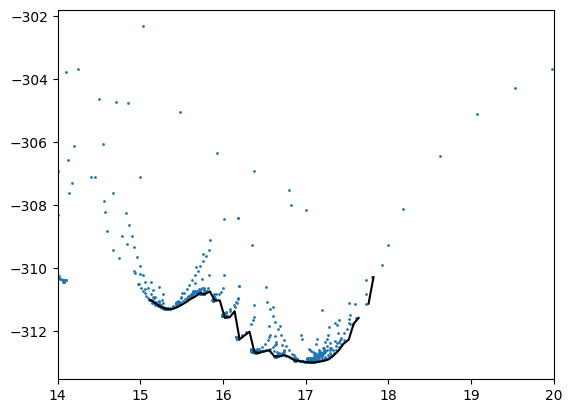

In [107]:
plt.scatter(x, y, s=1.0)
plt.plot(buckets, energies, color='black')
plt.xlim([14, 20])